In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

load_dotenv("../.env")
engine = create_engine(os.getenv('DB_URL'))
df = pd.read_sql('select * from bronze.online_retail', engine)
print(f"Total rows: {len(df):,}")
print(df.dtypes)

Total rows: 541,909
invoiceno                          str
stockcode                          str
description                        str
quantity                         int64
invoicedate             datetime64[us]
unitprice                      float64
customerid                     float64
country                            str
_load_timestamp    datetime64[us, UTC]
_source_file                       str
dtype: object


In [2]:
# Null analysis
null_report = (df.isnull().sum() / len(df)*100).round(2)
print(null_report[null_report > 0])

description     0.27
customerid     24.93
dtype: float64


In [4]:
# Refund analysis
refunds = df[df['quantity']<0]
print(f"Refunds rows: {len(refunds):,}")
print(f"Refund revenue: {(refunds.quantity * refunds.unitprice).sum():,.0f}")
print(f"Refund % of rows: {len(refunds)/len(df)*100:.1f}%")

Refunds rows: 10,624
Refund revenue: -896,812
Refund % of rows: 2.0%


In [6]:
# Duplicates Analysis
dupes = df.duplicated(subset =['invoiceno','stockcode','quantity','unitprice']).sum()
print(f"Duplicate rows:  {dupes:,}")

Duplicate rows:  5,271


In [7]:
# Bad prices
print(f"Zero price rows: {(df.unitprice == 0).sum():,}")
print(f"Price > 500: {(df.unitprice>500).sum():,}")
print(df[df.unitprice > 500][['stockcode','description','unitprice']].head(10))

Zero price rows: 2,515
Price > 500: 255
       stockcode     description  unitprice
1817         DOT  DOTCOM POSTAGE     569.77
3043         DOT  DOTCOM POSTAGE     607.49
6173         DOT  DOTCOM POSTAGE     887.52
10824        DOT  DOTCOM POSTAGE     863.74
11394        DOT  DOTCOM POSTAGE     940.87
13943        DOT  DOTCOM POSTAGE     950.99
14412          M          Manual     924.59
14737          M          Manual     631.31
15038  AMAZONFEE      AMAZON FEE   13541.33
15039  AMAZONFEE      AMAZON FEE   13541.33


In [10]:
# Non-product codes
non_prod = ['post','dot','m','bank charges','amazonfee','pads','d','cruk']
print(f"Non-product rows: {df.stockcode.isin(non_prod).sum():,}")
print(df[df.stockcode.isin(non_prod)]['stockcode'].value_counts())

Non-product rows: 1
stockcode
m    1
Name: count, dtype: int64


In [11]:
# Revenue-By-Country
df['revenue'] = df['quantity']*df['unitprice']
country = df[df.revenue>0].groupby('country')['revenue'].sum().sort_values(ascending=False)
print(country.head(10))

country
United Kingdom    9025222.084
Netherlands        285446.340
EIRE               283453.960
Germany            228867.140
France             209715.110
Australia          138521.310
Spain               61577.110
Switzerland         57089.900
Belgium             41196.340
Sweden              38378.330
Name: revenue, dtype: float64


month
2010-12     823746.140
2011-01     691364.560
2011-02     523631.890
2011-03     717639.360
2011-04     537808.621
2011-05     770536.020
2011-06     761739.900
2011-07     719221.191
2011-08     737014.260
2011-09    1058590.172
2011-10    1154979.300
2011-11    1509496.330
2011-12     638792.680
Freq: M, Name: revenue, dtype: float64
Chart Saved!!


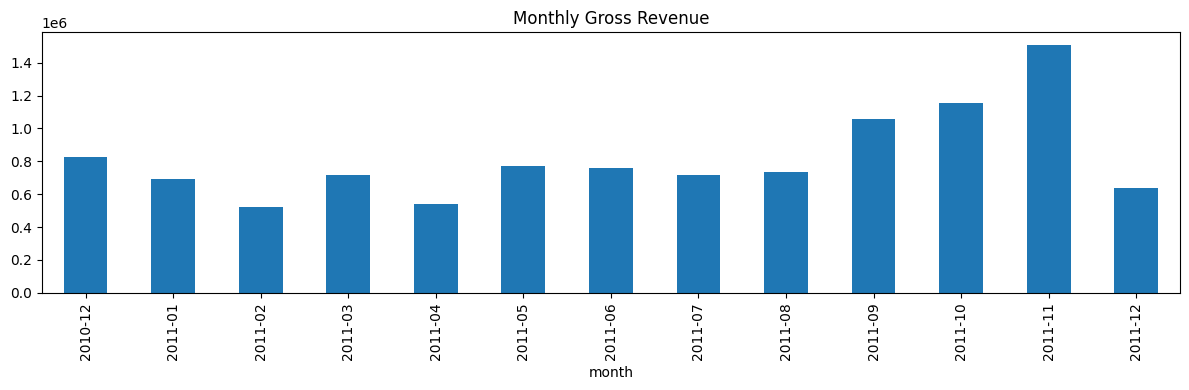

In [13]:
# Monthly revenue pattern
df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df['month'] = df['invoicedate'].dt.to_period('M')
monthly = df[df['quantity']>0].groupby('month')['revenue'].sum()
print(monthly)

monthly.plot(kind ='bar', figsize=(12,4), title = 'Monthly Gross Revenue')
plt.tight_layout()
plt.savefig('../docs/monthly_revenue_profile.png', dpi=150)
print('Chart Saved!!')